# Preparación
Se monta el sistema de archivos de google drive.


In [25]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-01-09 10:23:56.117648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:23:56.118287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:23:56.118608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:23:56.119079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:23:56.119418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

'/device:GPU:0'

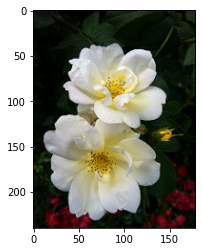

In [26]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/flowers-with-train-and-val-separation/flowers_with_train_and_val_separation/flowers_train/rose/10090824183_d02c613f10_m.jpg', 'r')
imshow(np.asarray(pil_im))



# Data augmentation para prevenir el sobreajuste

In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)

# Carga del dataset

In [29]:
image_size = (150, 150)
batch_size = 32


train_data_dir = '../input/flowers-with-train-and-val-separation/flowers_with_train_and_val_separation/flowers_train'
validation_data_dir = '../input/flowers-with-train-and-val-separation/flowers_with_train_and_val_separation/flowers_val'


train_ds = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
)

val_ds = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
)

Found 3997 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


# Modelo

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten, BatchNormalization, GlobalAveragePooling2D

In [31]:
model = keras.Sequential()

model.add(Rescaling(scale=(1./255), input_shape=(150, 150, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Visualización del modelo

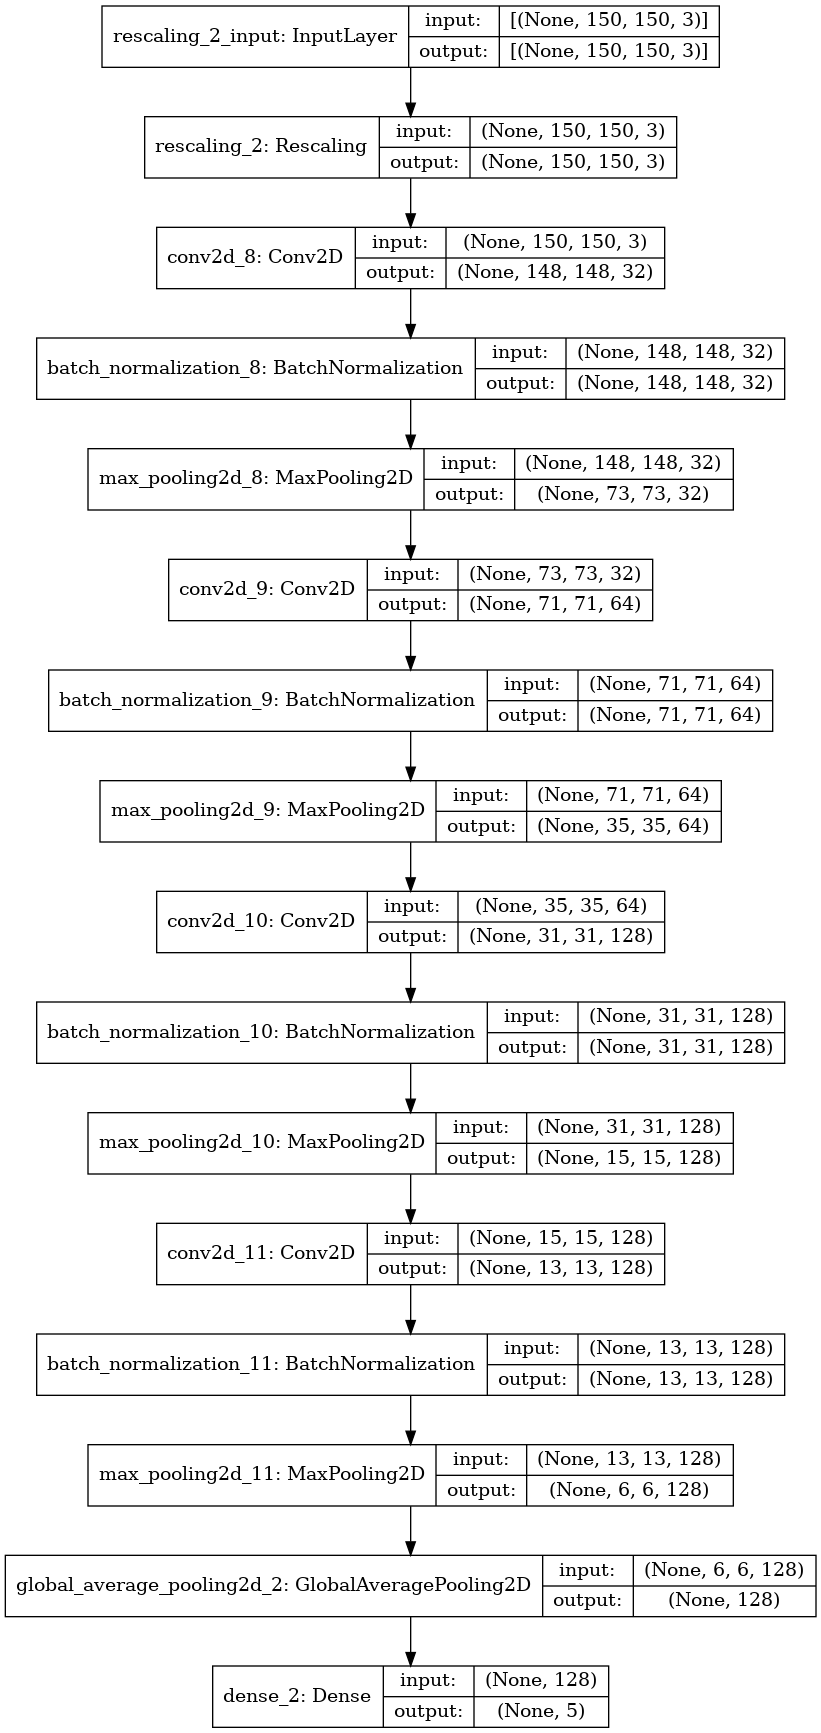

In [32]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

# Entrenamiento

In [33]:
from keras.callbacks import EarlyStopping

epochs = 150

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30,
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/150
125/125 [==============================] - 38s 303ms/step - loss: 1.2052 - accuracy: 0.5171 - val_loss: 1.7656 - val_accuracy: 0.2000
Epoch 2/150
125/125 [==============================] - 36s 288ms/step - loss: 1.0175 - accuracy: 0.5972 - val_loss: 2.3838 - val_accuracy: 0.2000
Epoch 3/150
125/125 [==============================] - 35s 277ms/step - loss: 0.9048 - accuracy: 0.6432 - val_loss: 2.4544 - val_accuracy: 0.2000
Epoch 4/150
125/125 [==============================] - 30s 238ms/step - loss: 0.8430 - accuracy: 0.6775 - val_loss: 2.1167 - val_accuracy: 0.2000
Epoch 5/150
125/125 [==============================] - 30s 241ms/step - loss: 0.7634 - accuracy: 0.7050 - val_loss: 1.6661 - val_accuracy: 0.3200
Epoch 6/150
125/125 [==============================] - 30s 242ms/step - loss: 0.7343 - accuracy: 0.7248 - val_loss: 1.0202 - val_accuracy: 0.6125
Epoch 7/150
125/125 [==============================] - 29s 235ms/step - loss: 0.6772 - accuracy: 0.7433 - val_loss: 0.9439 -

# Gráfica de evolución de pérdida y exactitud durante el entrenamiento

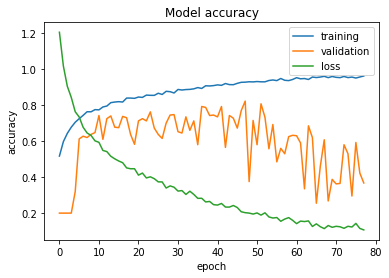

In [37]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

# Evaluación de los resultados

In [35]:
#import numpy as np
#from sklearn.metrics import classification_report, confusion_matrix
#import seaborn as sns
#
#results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)
#
#predictions = np.argmax(results[0], axis=1)
#labels = np.argmax(results[1], axis=1)
#
#cf_matrix = confusion_matrix(labels, predictions)
#
#sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")
#
#print(classification_report(labels, predictions, digits = 4))

In [42]:
img = keras.preprocessing.image.load_img(
    '../input/flowers-with-train-and-val-separation/flowers_with_train_and_val_separation/flowers_train/rose/102501987_3cdb8e5394_n.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

2
